# **Domingo salida**

# Importación de _data_

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import fs
%matplotlib inline

In [23]:
from IPython.display import HTML

# Reading data

In [24]:
DATA_DIR = './data'
data_dir = fs.open_fs(DATA_DIR)
OUT_DIR = './out'
out_dir = fs.open_fs(OUT_DIR)

In [25]:
DATA_FILENAME= 'domingo - salida.xlsx'
data_dir.exists(DATA_FILENAME)
buffer = data_dir.openbin(DATA_FILENAME)

In [26]:
try:
    out_dir = out_dir.makedir(DATA_FILENAME)
except:
    out_dir = out_dir.opendir(DATA_FILENAME)

# Rows

In [27]:
# rows
first_row = ['', 'moto', 'auto', 'station_wagon', '  ', 'camion']
second_row = ['bicicleta', 'moto_lineal', 'trimoto', 'moto_carga', 'particular', 'colectivo', 'taxi', 'particular', 'colectivo', 'taxi', 'miniban', 'microbus',  'camioneta','bus', 'tractores', '<12tn', '>12tn']
column_index = pd.MultiIndex.from_tuples([
    *zip( ((first_row[0] * 1, ) + (first_row[1], ) * 3 + (first_row[2], ) * 3 + (first_row[3], ) * 3 + (first_row[4], ) * 4 + (first_row[5], ) * 3), second_row )
])

In [28]:
data = pd.read_excel(buffer, index_col=0, sheet_name='Hoja2')
# data = data.dropna(data.index.isnull())
data = data[data.index.notnull()]
# data = data.set_index('Hora')
data.columns = column_index
hora = data.index.str.extract('^(\d?\d:\d\d)').astype('string').values
data.index = pd.Index(hora.ravel(), name='hora', dtype=str)
data.index = pd.to_datetime(data.index)
data = data.infer_objects()
data.to_excel(out_dir.getospath(path='data_original.xlsx').decode('utf-8'))
data.head()

moto                          auto  \
                    bicicleta moto_lineal trimoto moto_carga particular   
hora                                                                      
2022-10-06 06:00:00         0           2       1          0         25   
2022-10-06 06:15:00         0           0       0          0         24   
2022-10-06 06:30:00         1           4       2          0         25   
2022-10-06 06:45:00         0           6       1          1         26   
2022-10-06 07:00:00         0           5       2          3         25   

                                   station_wagon                         \
                    colectivo taxi    particular colectivo taxi miniban   
hora                                                                      
2022-10-06 06:00:00         7    8             9         0    1     0.0   
2022-10-06 06:15:00         1    5             7         0    2     6.0   
2022-10-06 06:30:00         8    4             2         0    0     3.0   
2022-10-06 06:45:00         3    8             6         0    4     5.0   
2022-10-06 07:00:00         1   11             0         0    4     3.0   

                                               camion              
                    microbus camioneta  bus tractores <12tn >12tn  
hora                                                               
2022-10-06 06:00:00      1.0       9.0  1.0       0.0     2     2  
2022-10-06 06:15:00      5.0      13.0  0.0       0.0     2     1  
2022-10-06 06:30:00      6.0      14.0  1.0       0.0     4     1  
2022-10-06 06:45:00      3.0      17.0  1.0       0.0     4     0  
2022-10-06 07:00:00      5.0      17.0  0.0       0.0     7     1

In [29]:
data.shape

(64, 17)

## Gráficas por tipo

In [30]:
period = '15T' # -> 15 minutos
data_resampled = data.resample(rule=period,label='right',closed='left').sum()

In [31]:
from time import strftime

_ = data_resampled.copy(deep=True)
_['hora'] = _.index.to_pydatetime()
_['hora'] = _['hora'].apply(lambda x: '{}'.format((x - pd.Timedelta('15T')).strftime('%H:%M')) + ' a ' + x.strftime('%H:%M'))
_.index.name = ""
# _.drop_index()
_.reset_index()
_ = _.set_index('hora')
_.to_excel(out_dir.getospath(path='data_resampled.xlsx').decode('utf-8'))

In [32]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('bright', 4))

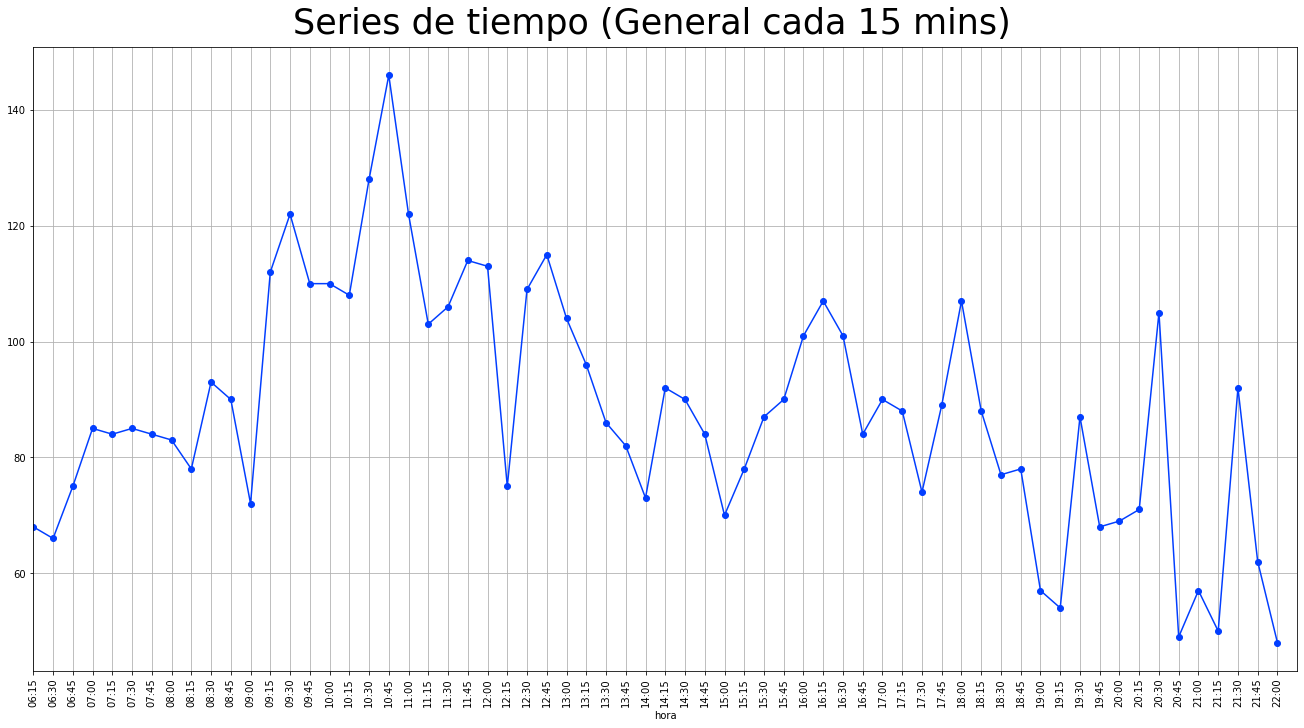

In [33]:
x_labels = data_resampled.index.astype('string').str.extract('(\d\d:\d\d):\d\d$').values.ravel().tolist()
x_ticks = pd.to_datetime(x_labels).tolist() 
# x_ticks += [max(x_ticks) + pd.Timedelta(period)]
# x_labels += [str(max(x_ticks) + pd.Timedelta(period))]

fig, axes = plt.subplots(figsize=(18,10), layout='constrained')
fig.suptitle("Series de tiempo (General cada 15 mins)", size=35)
data_resampled.sum(axis=1).plot(ax = axes, xticks=x_ticks,rot=90, grid=True, marker='o', colormap=cmap, xlim=(min(x_ticks), max(x_ticks) + pd.Timedelta(period)))
axes.set_xticklabels(x_labels)
fig.savefig(out_dir.getospath('series_de_tiempo_15.pdf').decode('utf-8'), format='pdf')
plt.show()

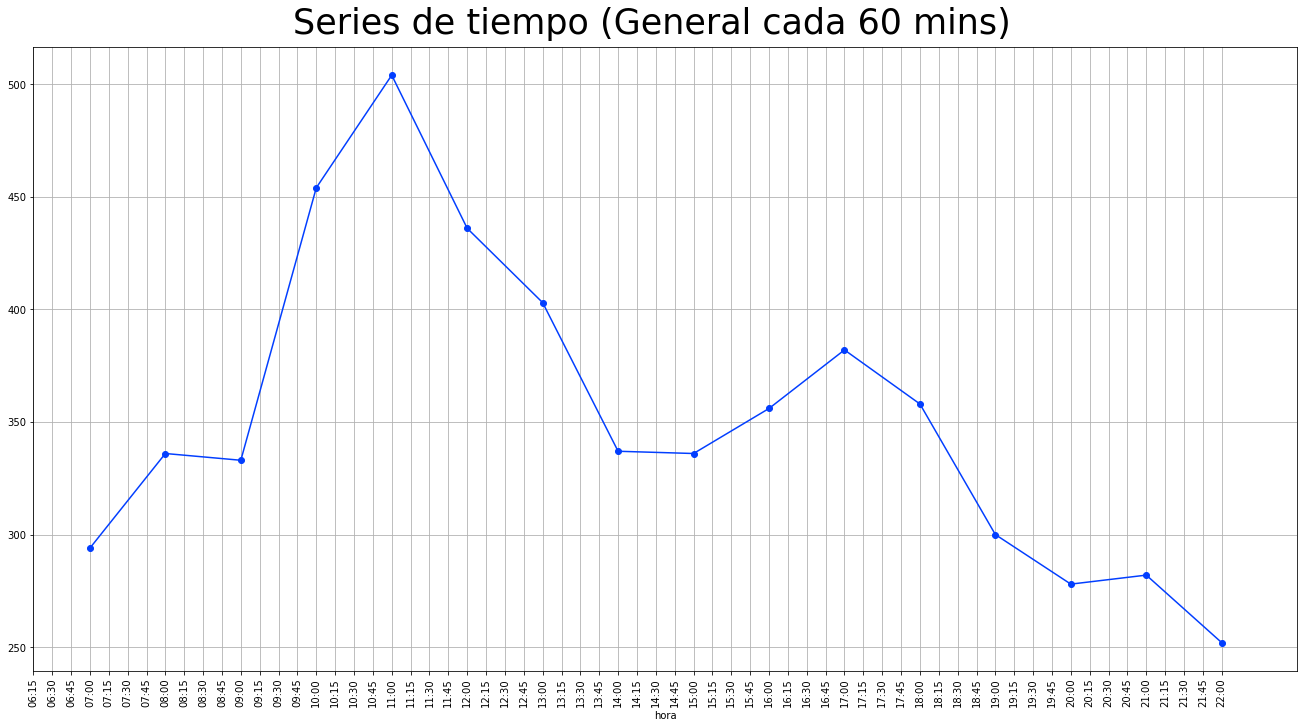

In [34]:
x_labels_ = data_resampled.index.astype('string').str.extract('(\d\d:\d\d):\d\d$').values.ravel().tolist()
x_ticks_ = pd.to_datetime(x_labels).tolist() 
period_ = '60T' # -> 15 minutos
data_resampled_ = data.resample(rule=period_,label='right',closed='left').sum()
fig, axes = plt.subplots(figsize=(18,10), layout='constrained')
fig.suptitle("Series de tiempo (General cada 60 mins)", size=35)
data_resampled_.sum(axis=1).plot(ax = axes, xticks=x_ticks_,rot=90, grid=True, colormap=cmap, marker='o', xlim=(min(x_ticks_), max(x_ticks_) + pd.Timedelta(period_)))
axes.set_xticklabels(x_labels_)
fig.savefig(out_dir.getospath('series_de_tiempo_60.pdf').decode('utf-8'), format='pdf')
plt.show()

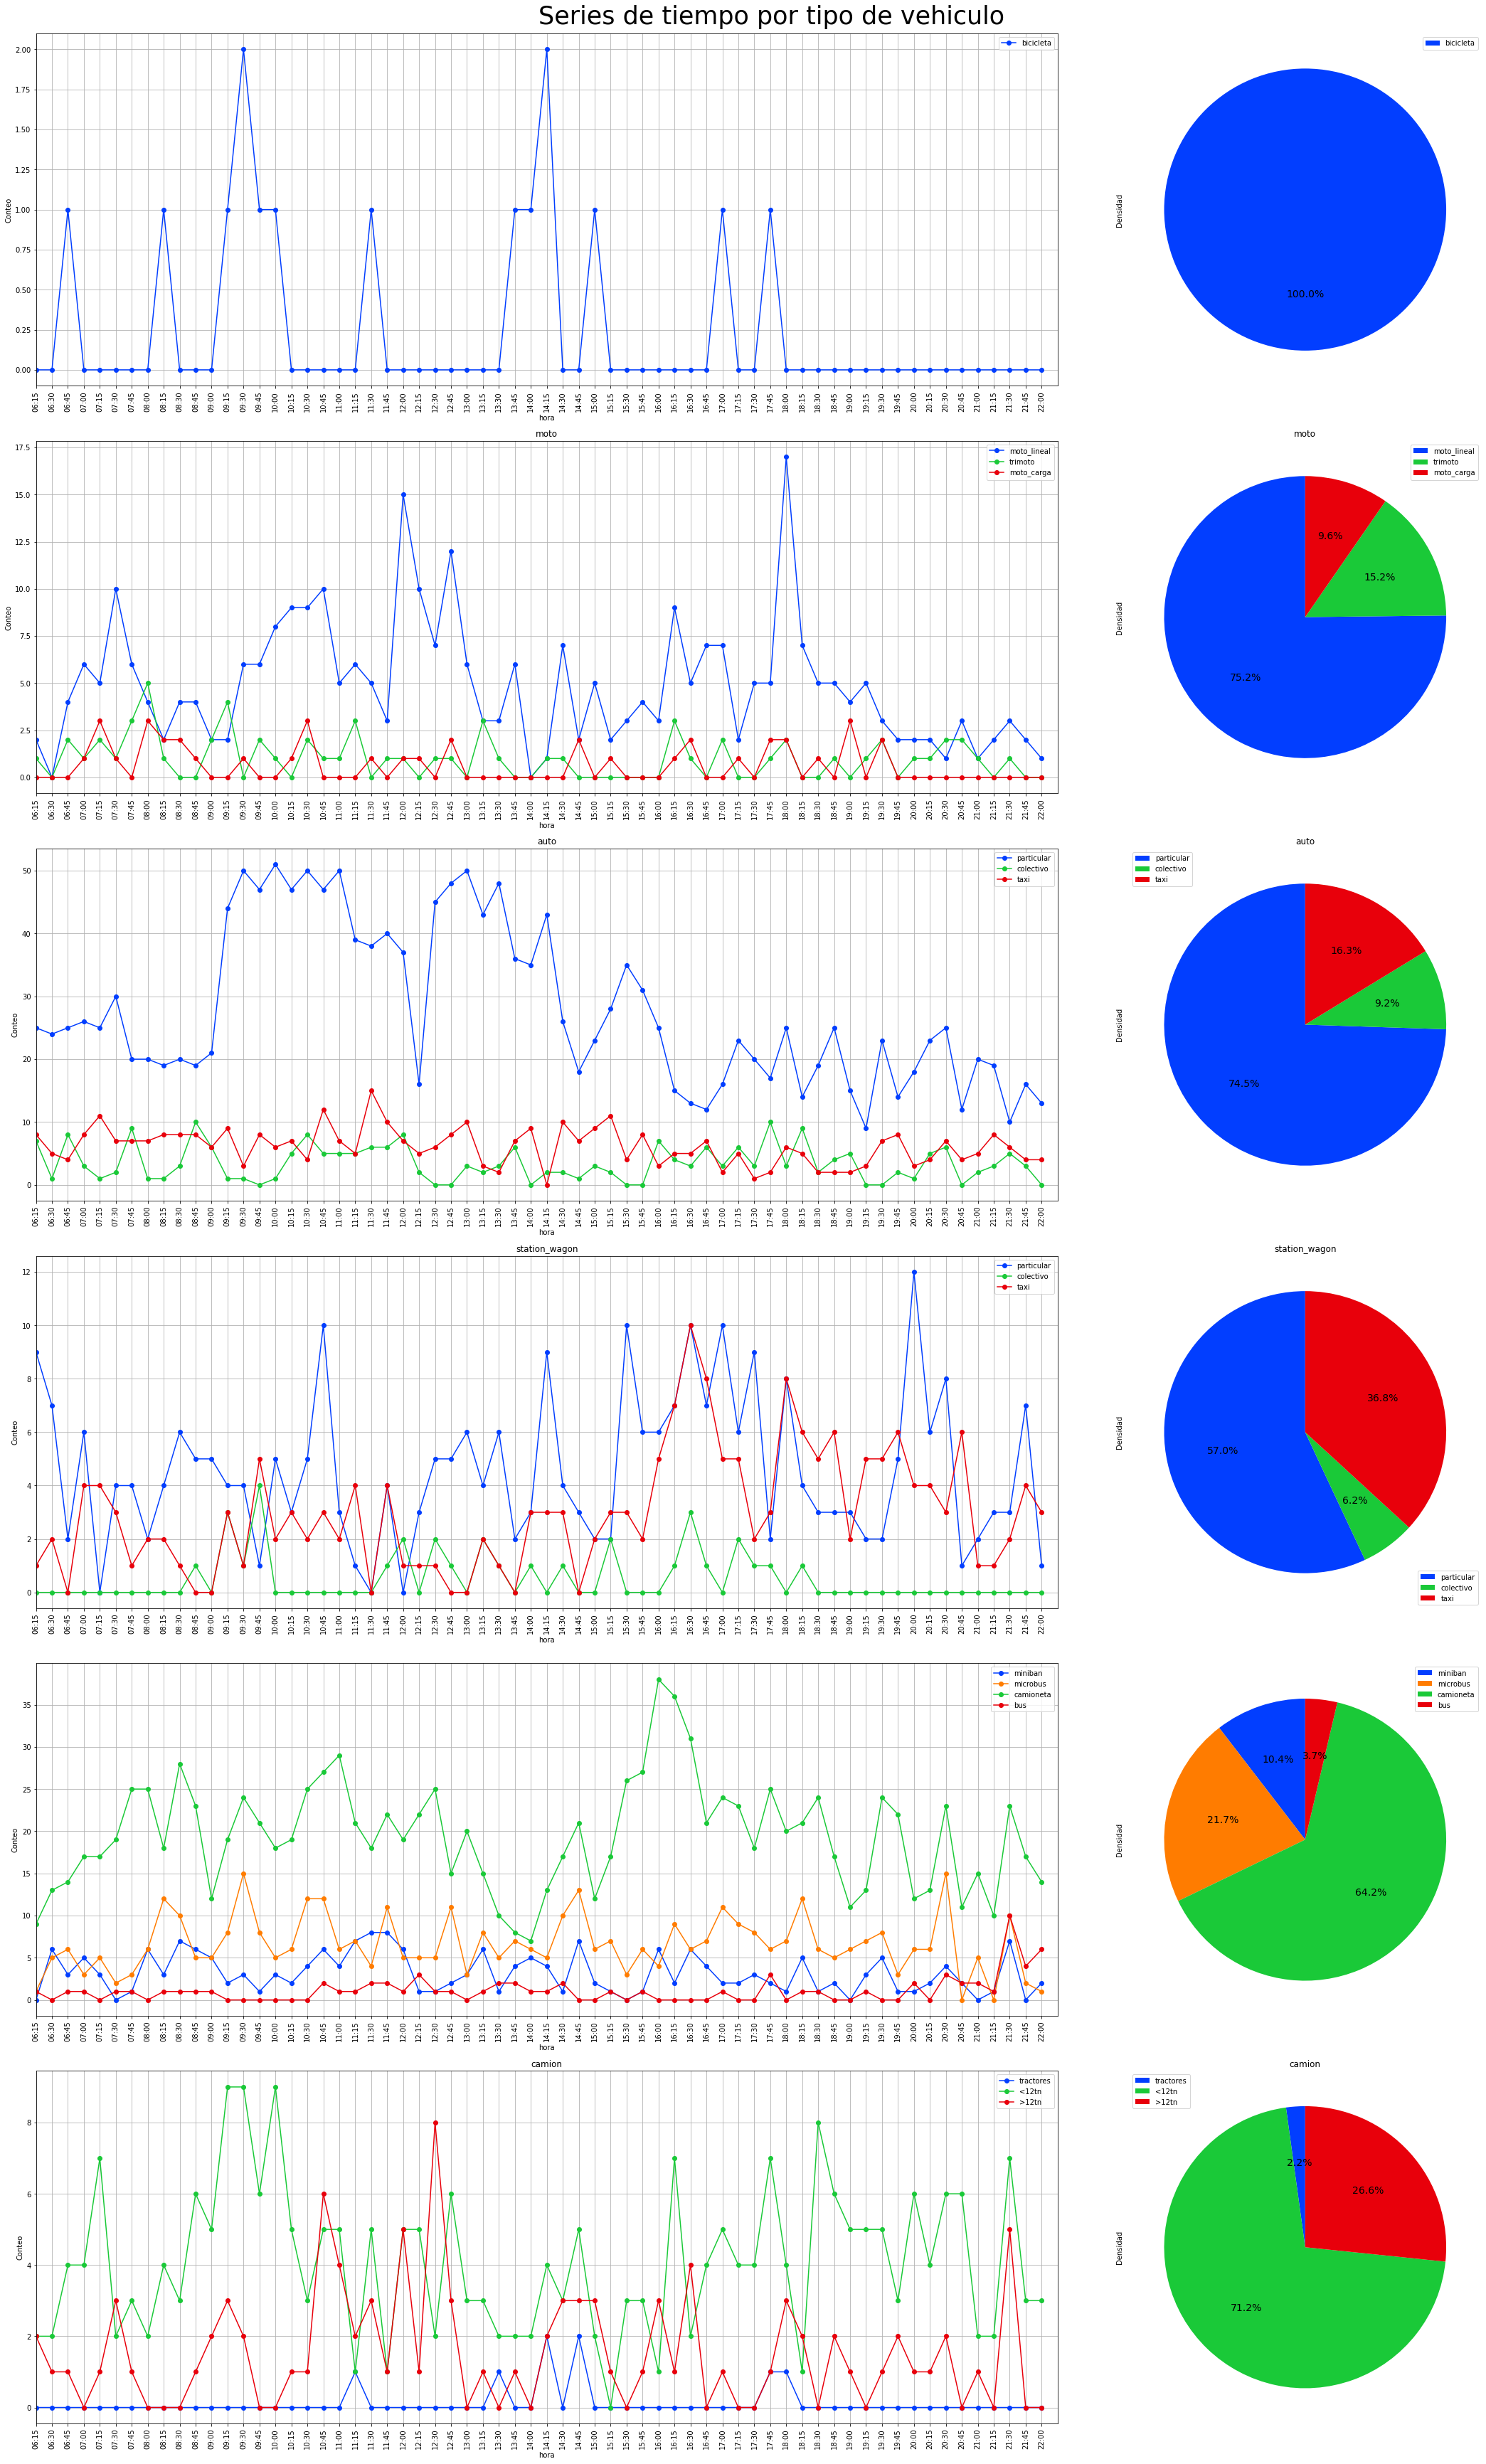

In [35]:
counter_idx = 0
g = []
pies = []
fig, axes = plt.subplots(len(first_row), 2, figsize=(30,48), gridspec_kw={'width_ratios': [2.2, 1],}, layout='constrained')
# fig.tight_layout()
fig.suptitle("Series de tiempo por tipo de vehiculo", size=35)
for ax, column_1 in zip(axes.reshape(-1,2), first_row):
    data_ = data_resampled[column_1]
    data_.plot(ax=ax[0], xticks=x_ticks,rot=90, grid=True, title=column_1, colormap=cmap, marker='o', xlim=(min(x_ticks), max(x_ticks) + pd.Timedelta(period)))
    ax[0].set_xticklabels(x_labels)
    ax[0].set_ylabel('Conteo')
    ax[1].set_title(column_1)
    data_.sum(axis=0).plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, fontsize=14)
    ax[1].set_ylabel('Densidad')
# plt.xticks(ticks = data_resampled.index,labels=[str(i) for i in data_resampled.index])
fig.savefig(out_dir.getospath('series_por_tipo.pdf').decode('utf-8'), format='pdf')
plt.show()

# Valores estadísticos por tipo de carro

## Por tipo de carro

In [36]:
_ = data_resampled.describe()
_.to_excel(out_dir.getospath(path='resumen_1.xlsx').decode('utf-8'), sheet_name='por tipo de carro')
_

moto                             auto             \
       bicicleta moto_lineal    trimoto moto_carga particular  colectivo   
count  64.000000   64.000000  64.000000  64.000000  64.000000  64.000000   
mean    0.234375    4.875000   0.984375   0.625000  27.812500   3.453125   
std     0.495766    3.359422   1.105429   0.934353  12.581007   2.794153   
min     0.000000    0.000000   0.000000   0.000000   9.000000   0.000000   
25%     0.000000    2.000000   0.000000   0.000000  18.750000   1.000000   
50%     0.000000    4.500000   1.000000   0.000000  25.000000   3.000000   
75%     0.000000    6.000000   1.250000   1.000000  38.250000   5.250000   
max     2.000000   17.000000   5.000000   3.000000  51.000000  10.000000   

                 station_wagon                                              \
            taxi    particular  colectivo       taxi    miniban   microbus   
count  64.000000     64.000000  64.000000  64.000000  64.000000  64.000000   
mean    6.078125      4.593750   0.500000   2.968750   3.156250   6.578125   
std     2.902132      2.809953   0.890871   2.218027   2.283264   3.379700   
min     0.000000      0.000000   0.000000   0.000000   0.000000   0.000000   
25%     4.000000      2.750000   0.000000   1.000000   1.000000   5.000000   
50%     6.000000      4.000000   0.000000   3.000000   3.000000   6.000000   
75%     8.000000      6.000000   1.000000   4.000000   5.000000   8.000000   
max    15.000000     12.000000   4.000000  10.000000   8.000000  15.000000   

                                camion                        
       camioneta        bus  tractores      <12tn      >12tn  
count  64.000000  64.000000  64.000000  64.000000  64.000000  
mean   19.421875   1.109375   0.125000   4.093750   1.531250  
std     6.431087   1.594805   0.417855   2.098516   1.642383  
min     7.000000   0.000000   0.000000   0.000000   0.000000  
25%    14.750000   0.000000   0.000000   2.000000   0.000000  
50%    19.000000   1.000000   0.000000   4.000000   1.000000  
75%    24.000000   1.000000   0.000000   5.000000   2.000000  
max    38.000000  10.000000   2.000000   9.000000   8.000000

## Por tipo carro (2)

In [37]:
_ = data_resampled.groupby(level=0, axis=1).sum().describe()
_.to_excel(out_dir.getospath(path='resumen_2.xlsx').decode('utf-8'), sheet_name='por tipo de vehiculo')
_

,,,auto,camion,moto,station_wagon
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.234375,30.265625,37.343750,5.750000,6.484375,8.062500
std,0.495766,9.167302,13.602309,2.731358,4.027651,4.155222
min,0.000000,11.000000,12.000000,1.000000,0.000000,0.000000
25%,0.000000,23.750000,26.750000,4.000000,3.750000,5.000000
50%,0.000000,29.500000,35.500000,5.000000,6.000000,7.000000
75%,0.000000,36.250000,49.000000,8.000000,8.000000,10.250000
max,2.000000,50.000000,64.000000,12.000000,21.000000,23.000000


## Por tipo de carro (3)

In [38]:
_ = data_resampled.groupby(level=1, axis=1).sum().describe()
_.to_excel(out_dir.getospath(path='resumen_3.xlsx').decode('utf-8'), sheet_name='completo')
_

,<12tn,>12tn,bicicleta,bus,camioneta,colectivo,microbus,miniban,moto_carga,moto_lineal,particular,taxi,tractores,trimoto
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,4.093750,1.531250,0.234375,1.109375,19.421875,3.953125,6.578125,3.156250,0.625000,4.875000,32.406250,9.046875,0.125000,0.984375
std,2.098516,1.642383,0.495766,1.594805,6.431087,2.886365,3.379700,2.283264,0.934353,3.359422,12.823241,3.263213,0.417855,1.105429
min,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,3.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,14.750000,2.000000,5.000000,1.000000,0.000000,2.000000,22.750000,7.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000,1.000000,19.000000,3.500000,6.000000,3.000000,0.000000,4.500000,29.500000,8.500000,0.000000,1.000000
75%,5.000000,2.000000,0.000000,1.000000,24.000000,6.000000,8.000000,5.000000,1.000000,6.000000,41.000000,11.250000,0.000000,1.250000
max,9.000000,8.000000,2.000000,10.000000,38.000000,11.000000,15.000000,8.000000,3.000000,17.000000,57.000000,15.000000,2.000000,5.000000


In [39]:
def explode_generator(len):
    for i in range(len):
        if i % 2:
            yield True
        else:
            yield False
exploder = list(explode_generator(len(second_row)))

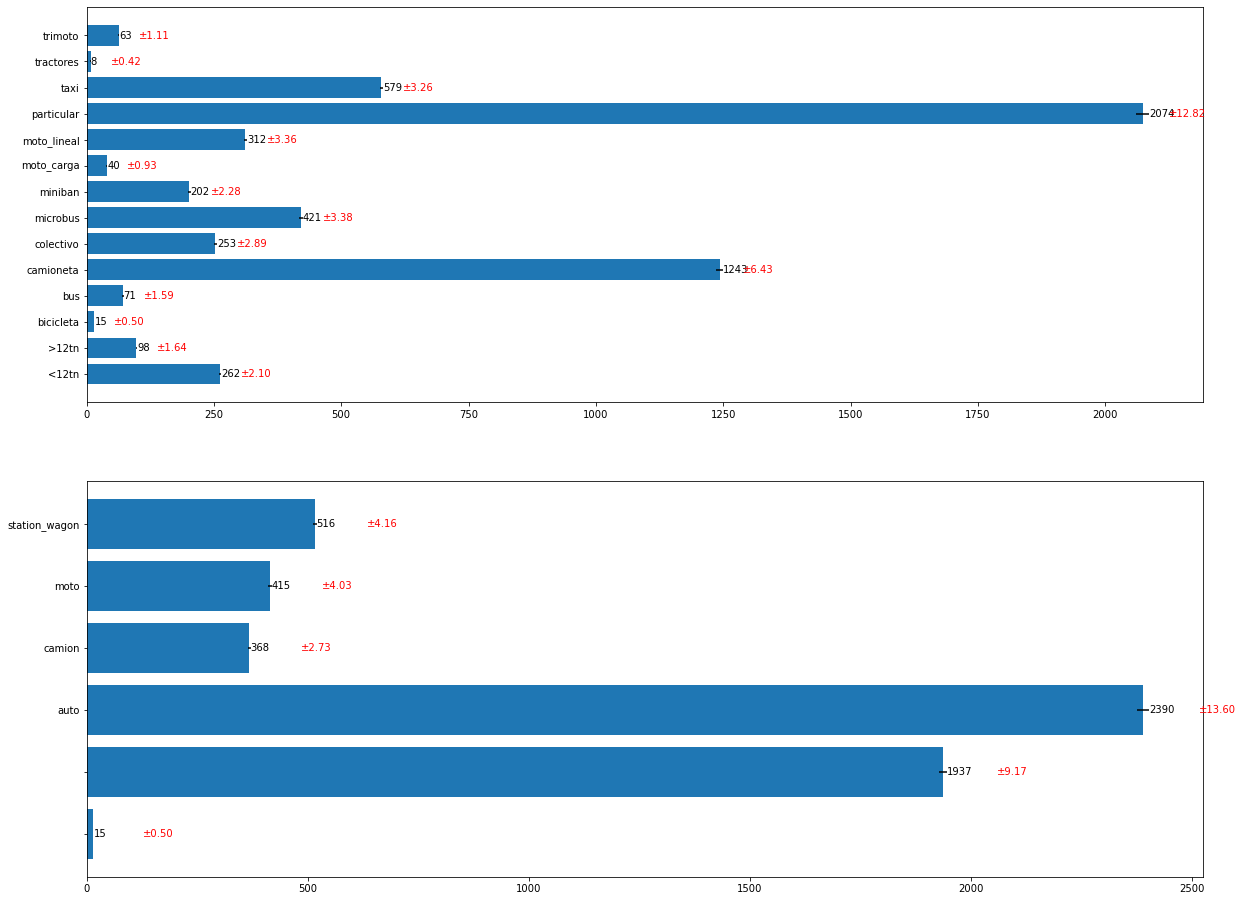

In [40]:
cmap = ListedColormap(sns.color_palette('bright', 2))
fig, ax = plt.subplots(2, 1, figsize=(20,16))
std_1 = data_resampled.groupby(level=1, axis=1).sum().std()
means_1 = data_resampled.groupby(level=1, axis=1).sum().mean()
data_1 = data_resampled.groupby(level=1, axis=1).sum().sum()
ah1 = ax[0].barh(data_1.index, width=data_1.tolist(), align='center', xerr=std_1)
ax[0].bar_label(ah1, fmt='%.0f')
ax[0].bar_label(ah1, labels=['±%.2f' % e for e in std_1.tolist()],
             padding=20 , color='r')

std_2 = data_resampled.groupby(level=0, axis=1).sum().std()
means_2 = data_resampled.groupby(level=0, axis=1).sum().mean()
data_2 = data_resampled.groupby(level=0, axis=1).sum().sum()
ah2 = ax[1].barh(data_2.index, width=data_2.tolist(), align='center', xerr=std_2)
ax[1].bar_label(ah2, fmt='%.0f')
ax[1].bar_label(ah2, labels=['±%.2f' % e for e in std_2.tolist()],
             padding=50 , color='r')
fig.savefig(out_dir.getospath('barras.pdf').decode('utf-8'), format='pdf')
plt.show()

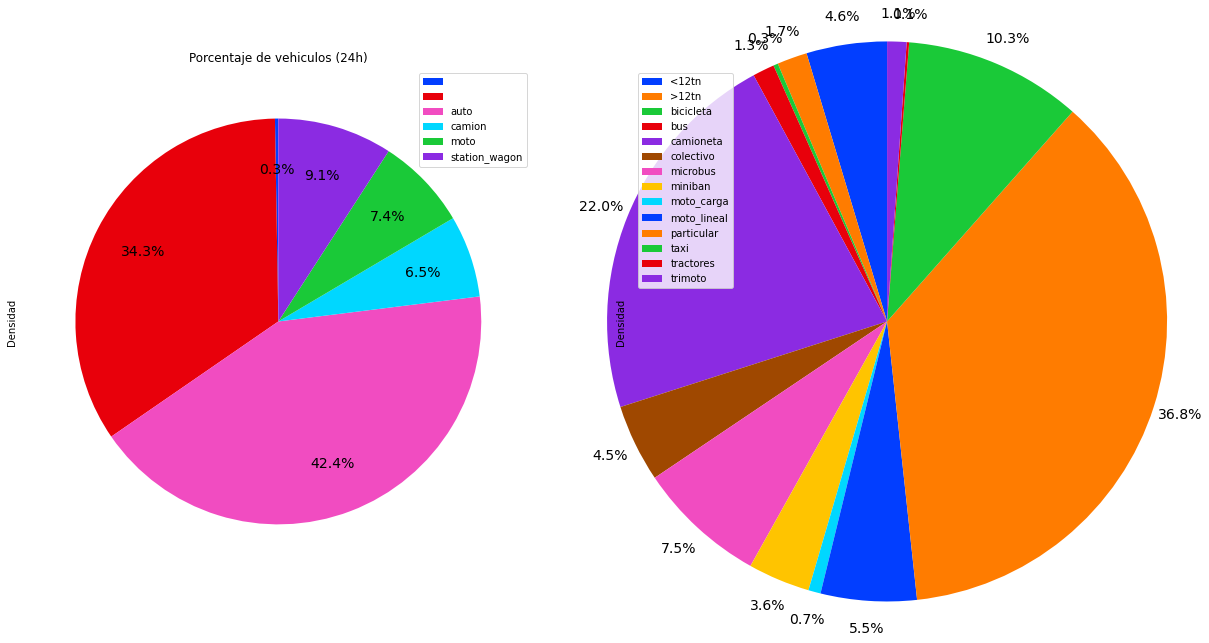

In [41]:
cmap = ListedColormap(sns.color_palette('bright', 15))
fig, ax = plt.subplots(1,2, figsize=(20,12))
fig.patch.set_facecolor('white')
ax[0].set_title("Porcentaje de vehiculos (24h)")
data.groupby(level=0, axis=1).sum().sum() \
    .plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, pctdistance=.75, labeldistance=1.2, fontsize=14, radius=1.0)
# ax[0].legend('lower left')
aaa = data.groupby(level=1, axis=1).sum().sum()
aaa \
    .plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, pctdistance=1.1, labeldistance=1.2, fontsize=14, radius=1.38)
# ax[1].legend()
ax[0].set_ylabel('Densidad')
ax[1].set_ylabel('Densidad')
fig.savefig(out_dir.getospath('pasteles.pdf').decode('utf-8'), format='pdf')
plt.show()

In [42]:
plt.close("all")